## Covid cases in the UK

This notebook analyses the COVID data in the UK. The data itself has been compiled by the UK government and is available through the website https://coronavirus.data.gov.uk/

Notice that since these statistics change every day, the results will also change.

First, let's import some necessary items

In [1]:
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from statsmodels import api as sm

Now, let's define the urls from where the data will be downloaded, as csv files, these can also be downloaded as JSON.

In [2]:
url_cases    = 'https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv'
url_deaths   = 'https://coronavirus.data.gov.uk/downloads/csv/coronavirus-deaths_latest.csv'

With these urls it is now possible to download the data from the urls and convert them to pandas DataFrames

In [3]:
cases_raw    = requests.get(url_cases).content
cases_csv    = pd.read_csv(io.StringIO(cases_raw.decode('utf-8')))
deaths_raw   = requests.get(url_deaths).content
deaths_csv   = pd.read_csv(io.StringIO(deaths_raw.decode('utf-8')))

Before any analysis or display, we can look into the structure of the DataFrame:

In [4]:
cases_csv.head()

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Cumulative lab-confirmed cases,Cumulative lab-confirmed cases rate
0,Adur,E07000223,ltla,2020-08-17,0,194,301.7
1,Adur,E07000223,ltla,2020-08-16,0,194,301.7
2,Adur,E07000223,ltla,2020-08-15,0,194,301.7
3,Adur,E07000223,ltla,2020-08-14,1,194,301.7
4,Adur,E07000223,ltla,2020-08-13,0,193,300.2


The fields include the area name (e.g. Adur), a specific code, Area type (**ltla** = lower tier local authority, **utla** = upper tier local authority, **region**, e.g. East Midlands, **nation**), dates, Daily and cummulative cases. 

Notice that the dates are going **down**, that is the first cases will be at the bottom of the table, this is important when we will display the data as it will mean that the first to be displayed is the most recent.

In [5]:
deaths_csv.head()

,"<?xml version=""1.0"" encoding=""utf-8""?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist."
0,RequestId:169a94a3-e01e-000a-6a7b-757f8d000000
1,Time:2020-08-18T16:18:52.8696202Z</Message></E...


For deaths, the fileds are similar, notice the difference in names for dates (**Reporting date/Specimen date**). General statistics can be extracted directly with describe():

In [7]:
cases_csv.describe()

,Daily lab-confirmed cases,Cumulative lab-confirmed cases,Cumulative lab-confirmed cases rate
count,77808.000000,77808.000000,77808.000000
mean,13.847959,1410.281128,289.762271
std,104.750416,9434.384837,200.430151
min,0.000000,1.000000,0.000000
25%,1.000000,188.000000,125.575000
50%,3.000000,472.000000,290.700000
75%,9.000000,983.000000,417.900000
max,4798.000000,275834.000000,1535.500000


In [8]:
deaths_csv.describe()

,"<?xml version=""1.0"" encoding=""utf-8""?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist."
count,2
unique,2
top,RequestId:349fdd5a-801e-0041-2a6b-7583de000000
freq,1


To display the graphs (that are shown everywhere...) we need the *Daily lab-confirmed cases* from the cases and the *Daily change in deaths* from the deaths. Let's first take the cases. We can extract the specimen date to create a time axis and the cases to create the values per time.

In [9]:
time_axis = cases_csv.loc[cases_csv['Area type']=='nation',['Specimen date']]
vert_axis = cases_csv.loc[cases_csv['Area type']=='nation',['Daily lab-confirmed cases']]
time_values = time_axis['Specimen date'];
vert_values = vert_axis['Daily lab-confirmed cases']

Let's also calculate the seven day rolling average number

In [10]:
sevenDayAv  = np.convolve(vert_values,np.ones(7,)/7, mode='same')

We can now display the data:

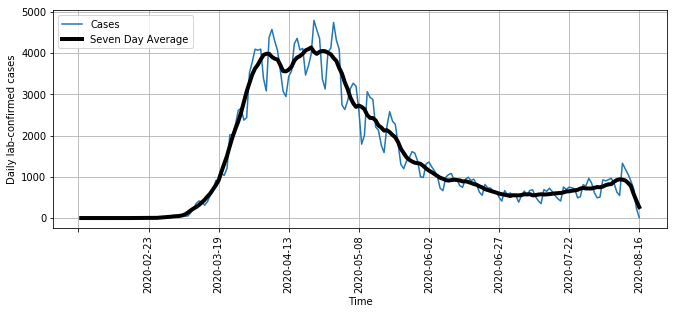

In [11]:
fig = plt.figure(figsize=(11, 4))
ax  = fig.add_subplot(111)
plt.plot(time_values,vert_values,label="Cases")
plt.plot(time_values,sevenDayAv,'k',label="Seven Day Average",linewidth=4)

plt.xlabel('Time')
plt.ylabel('Daily lab-confirmed cases')
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.invert_xaxis()
plt.legend(loc="upper left")
plt.grid()


The question (as of the 5th of August 2020) is if the cases are increasing, thus hinting a second wave coming. Let's zoom in to have a better look:

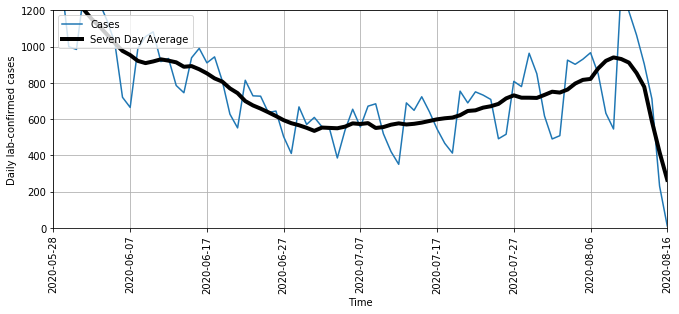

In [12]:
ax.set_xlim(0,80)
ax.set_ylim(0,1200)
ax.invert_xaxis()
fig

It does seem that the cases are going up. Let's look at deaths:

In [167]:
time_axisD = deaths_csv.loc[deaths_csv['Area type']=='UK',['Reporting date']]
vert_axisD = deaths_csv.loc[deaths_csv['Area type']=='UK',['Daily change in deaths']]
time_valuesD = time_axisD['Reporting date'];
vert_valuesD = vert_axisD['Daily change in deaths']
sevenDayAvD  = np.convolve(vert_valuesD,np.ones(7,)/7, mode='same')

KeyError: 'Area type'

In [ ]:
len(time_valuesD)

In [ ]:
fig2 = plt.figure(figsize=(11, 4))
ax2  = fig2.add_subplot(111)
plt.plot(time_valuesD,vert_valuesD,label="Deaths")
plt.plot(time_valuesD,sevenDayAvD,'k',label="Seven Day Average",linewidth=4)

plt.xlabel('Time')
plt.ylabel('Daily change in deaths')
ax2.tick_params(axis='x', rotation=90)
ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.invert_xaxis()
plt.legend(loc="upper left")
plt.grid()


In this case, it does not seem that the deaths are rising, this may be due to several factors, better knowledge of the disease and treatment, or simply that the new cases will develop and then in 2-3 weeks time the deaths will start rising.

Now, let's look at some regions. For the sake of analysis I have selected nine different regions:

In [ ]:
testRegions=['Adur','Barrow-in-Furness','Carlisle','Guildford','Mid Sussex',
     'North Devon','New Forest','Stafford','Worthing']

Now I am going to display each of them in a separate subplot. So that they are easy to compare visually, let's set all to have the same vertical axis.

In [ ]:
fig3 = plt.figure(figsize=(11, 7))

for counter in range(len(testRegions)):
    ax331  = fig3.add_subplot(3,3,counter+1)
    plt.plot(cases_csv.loc[cases_csv['Area name']==testRegions[counter],['Daily lab-confirmed cases']]) 
    plt.grid()
    ax331.invert_xaxis()
    ax331.set_ylim(0,60)
    ax331.set_title(testRegions[counter])
    ax331.set_xticks([])

Some names (e.g. Coventry) appear both in the upper tier and lower tier local authority, thus if we do not distinguish between these and try to display, it does not work:

In [ ]:
plt.plot(cases_csv.loc[cases_csv['Area name']=='Coventry',['Daily lab-confirmed cases']]) 

What we see is that there are cases of Coventry around the rows 10,000 and 50,000 of the csv file and the rest is empty. Thus we need to select over two columns to make the correct selection. E.g. for lower tier:

In [14]:
(cases_csv['Area type']=='ltla')&(cases_csv['Area name']=='Coventry')

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
77778    False
77779    False
77780    False
77781    False
77782    False
77783    False
77784    False
77785    False
77786    False
77787    False
77788    False
77789    False
77790    False
77791    False
77792    False
77793    False
77794    False
77795    False
77796    False
77797    False
77798    False
77799    False
77800    False
77801    False
77802    False
77803    False
77804    False
77805    False
77806    False
77807    False
Length: 77808, dtype: bool

And the actual values are extracted like this:

In [15]:
cases_csv.loc[(cases_csv['Area type']=='ltla')&(cases_csv['Area name']=='Coventry'),['Daily lab-confirmed cases']]

,Daily lab-confirmed cases
10681,0
10682,5
10683,20
10684,9
10685,8
10686,11
10687,12
10688,3
10689,10
10690,11


In [16]:
cases_csv.loc[(cases_csv['Area type']=='utla')&(cases_csv['Area name']=='Coventry'),['Daily lab-confirmed cases']]

,Daily lab-confirmed cases
57603,0
57604,5
57605,20
57606,9
57607,8
57608,11
57609,12
57610,3
57611,10
57612,11


We can now display, and let's compare two different local authorities, Coventry and Leicester

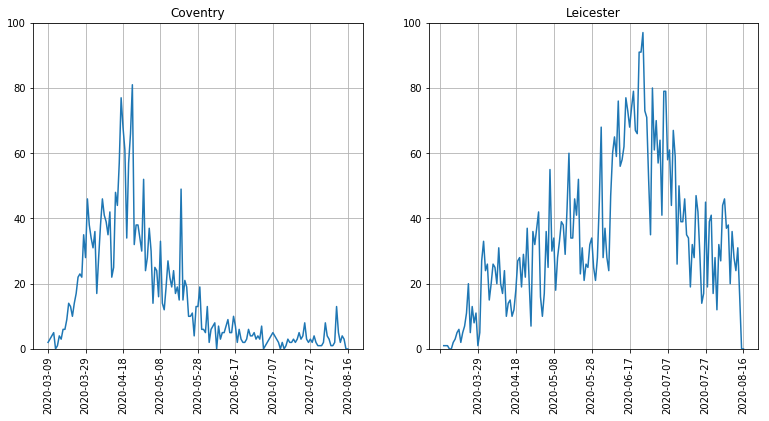

In [142]:
fig4 = plt.figure(figsize=(13, 6))

index_ltla_Coventry  = (cases_csv['Area type']=='ltla')&(cases_csv['Area name']=='Coventry')
index_ltla_Leicester = (cases_csv['Area type']=='ltla')&(cases_csv['Area name']=='Leicester')
time_Coventry        = cases_csv.loc[index_ltla_Coventry,['Specimen date']]
time_Leicester       = cases_csv.loc[index_ltla_Leicester,['Specimen date']]#time_values = time_axis['Specimen date'];
cases_Coventry       = cases_csv.loc[index_ltla_Coventry,['Daily lab-confirmed cases']]
cases_Leicester       = cases_csv.loc[index_ltla_Leicester,['Daily lab-confirmed cases']]

ax211  = fig4.add_subplot(1,2,1)
plt.plot(time_Coventry['Specimen date'], cases_Coventry) 
plt.grid()
ax211.invert_xaxis()
ax211.set_ylim(0,100)
ax211.set_title('Coventry')
ax211.tick_params(axis='x', rotation=90)
ax211.xaxis.set_major_locator(ticker.AutoLocator())


ax212  = fig4.add_subplot(1,2,2)
plt.plot(time_Leicester['Specimen date'],cases_Leicester) 
plt.grid()
ax212.invert_xaxis()
ax212.set_ylim(0,100)
ax212.set_title('Leicester')
ax212.tick_params(axis='x', rotation=90)
ax212.xaxis.set_major_locator(ticker.AutoLocator())


The growth of Leicester is significant as compared with Coventry, and that would explain the reasons to impose a specific lockdown in Leicester, which seems to have worked as the numbers have decreased, whilst Coventry seems to be starting to go up.

Thus, it would be interesting to observe in which local authorities the numbers are going up and in which they are going down. 

So, let's first identify the local authorities. The lower tier can be obtained like this:

In [101]:
LocalAuthorities=pd.Series.unique(cases_csv.loc[cases_csv['Area type']=='ltla', 'Area name'])
len(LocalAuthorities)

315

Mmmh, 315 are a big number, let's take the upper tier:


In [138]:
LocalAuthorities=pd.Series.unique(cases_csv.loc[cases_csv['Area type']=='utla', 'Area name'])
numLocalAuthorities = len(LocalAuthorities)
numLocalAuthorities

149

This number is more manageable, let's list them:

In [139]:
LocalAuthorities

array(['Barking and Dagenham', 'Barnet', 'Barnsley',
       'Bath and North East Somerset', 'Bedford', 'Bexley', 'Birmingham',
       'Blackburn with Darwen', 'Blackpool', 'Bolton',
       'Bournemouth, Christchurch and Poole', 'Bracknell Forest',
       'Bradford', 'Brent', 'Brighton and Hove', 'Bristol, City of',
       'Bromley', 'Buckinghamshire', 'Bury', 'Calderdale',
       'Cambridgeshire', 'Camden', 'Central Bedfordshire',
       'Cheshire East', 'Cheshire West and Chester',
       'Cornwall and Isles of Scilly', 'County Durham', 'Coventry',
       'Croydon', 'Cumbria', 'Darlington', 'Derby', 'Derbyshire', 'Devon',
       'Doncaster', 'Dorset', 'Dudley', 'Ealing',
       'East Riding of Yorkshire', 'East Sussex', 'Enfield', 'Essex',
       'Gateshead', 'Gloucestershire', 'Greenwich',
       'Hackney and City of London', 'Halton', 'Hammersmith and Fulham',
       'Hampshire', 'Haringey', 'Harrow', 'Hartlepool', 'Havering',
       'Herefordshire, County of', 'Hertfordshire', 'Hil

We can select the numbers corresponding to each local authority and then extract a number of metrics, let's just take the following maximum cases and trend (i.e. going up or down).

The maximum can be easily obtained with np.max

In [190]:
np.max(cases_csv.loc[(cases_csv['Area type']=='utla')&(cases_csv['Area name']=='Leicester'),['Daily lab-confirmed cases']])

Daily lab-confirmed cases    97
dtype: int64

The trend requires a bit more thought. All local authorities must have experienced an increase from when the cases started to be recorded, reached a peak and then decreased. What is more interesting is the later trends, like Leicester or Coventry. So, let's fit a line to the latter cases. We can do this with numpy least squares polynomial fit *np.polyfit*. The polyfit takes 3 arguments:
* the x values (a range of values of the same length as the y
* the y values, in this case the cases of the local authority
* the degree of the fitting polynomial

Let's calculate for both local authorities, for the whole series for the time being.

In [106]:
np.polyfit(np.arange(len(cases_Coventry)),cases_Coventry.values.flatten(),1)

array([0.06545829, 4.17181453])

In [107]:
np.polyfit(np.arange(len(cases_Leicester)),cases_Leicester.values.flatten(),1)

array([-0.22174588, 51.7254717 ])

Notice that we extracted the values from the dataframe and flattened them (cases_Coventry.values.flatten()). The first value is the slope and the second is the intercept.  

**REMEMBER** that the most recent date is on the top so a positive slope would actually reflect a reduction of cases (as for Coventry in the whole period) and a negative would be an increase (as for Leicester in the whole period).

Now to take the most recent days for analysis, which are the first values of the array. Let's take a month.


In [122]:
np.polyfit(np.arange(len(cases_Coventry[:30])),cases_Coventry[:30].values.flatten(),1)

array([-0.16551724,  9.73333333])

In [123]:
np.polyfit(np.arange(len(cases_Leicester[:30])),cases_Leicester[:30].values.flatten(),1)


array([ 0.43337041, 21.7827957 ])

The cases have inverted as Coventry is growing and Leicester is decreasing. We can now run for all the local authorities.

In [195]:
max_cases   = np.zeros(numLocalAuthorities)
slope_cases = np.zeros(numLocalAuthorities)
for i in np.arange(numLocalAuthorities):
    index_current   = (cases_csv['Area type']=='utla')&(cases_csv['Area name']==LocalAuthorities[i])
    cases_current   = cases_csv.loc[index_current,['Daily lab-confirmed cases']]
    max_cases [i]   = np.max(cases_current)
    temp            = np.polyfit(np.arange(len(cases_current[:30])),cases_current[:30].values.flatten(),1)
    slope_cases[i]  = -temp[0];

Now, we only need to sort the arrays for the maximum cases and the slopes, and we do not actually need the sorted values but the indexes so we use *np.argsort*.

In [196]:
indexMax   =(np.argsort(max_cases))
indexSlope =(np.argsort(slope_cases))

Let's check which cases have highest and lowest values:

In [194]:
LocalAuthorities[indexMax[:5]]

array(['Rutland', 'North East Lincolnshire', 'Windsor and Maidenhead',
       'Bath and North East Somerset', 'Bracknell Forest'], dtype=object)

In [198]:
LocalAuthorities[indexMax[-5:]]

array(['Surrey', 'Essex', 'Hampshire', 'Lancashire', 'Kent'], dtype=object)

In [199]:
LocalAuthorities[indexSlope[:5]]

array(['Kent', 'Leicester', 'Essex', 'Bradford', 'Trafford'], dtype=object)

In [200]:
LocalAuthorities[indexSlope[-5:]]

array(['Leeds', 'Oldham', 'Manchester', 'Birmingham', 'Northamptonshire'],
      dtype=object)